# Business Problem

![Logo](https://cdn.prod.website-files.com/5ffa4de03c5ff1202dcdba1b/6023dd79636c03bdff925d81_iyzico%20Speedinvest%20portfolio.jpg)

***Iyzico is a financial technology company that makes online shopping easier for both buyers and sellers.***
***It provides payment infrastructure for e-commerce companies, marketplaces and individual users.***
***It is expected to make a total transaction volume estimate based on merchant_id and day for the last 3 months of 2020.***

##################################################
## Dataset Story
##################################################

***Data from 7 member businesses from 2018 to 2020 are included.***

***Transaction: Number of transactions***

***MerchantID: IDs of member businesses***

***Paid Price: Payment amount***

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("iyzico_data.csv")
df.drop("Unnamed: 0", axis=1,inplace=True)
df.head()
df.tail()
df["transaction_date"].dtypes
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

In [3]:
df["transaction_date"].min() # Timestamp('2018-01-01 00:00:00')
df["transaction_date"].max() # Timestamp('2020-12-31 00:00:00')

Timestamp('2020-12-31 00:00:00')

In [4]:
# Total number of transactions at each member merchant
df["merchant_id"].unique()

array([   535,  42616,  46774,  86302, 124381, 129316,  57192],
      dtype=int64)

In [5]:
# Total payment amount at each member business
df.groupby("merchant_id").agg({"Total_Paid":"sum"})

,Total_Paid
merchant_id,
535,156601530.234
42616,354583091.808
46774,1567200341.286
57192,317337137.586
86302,2870446.716
124381,1158692543.973
129316,1555471.476


### Transaction count graphs of member businesses in each year

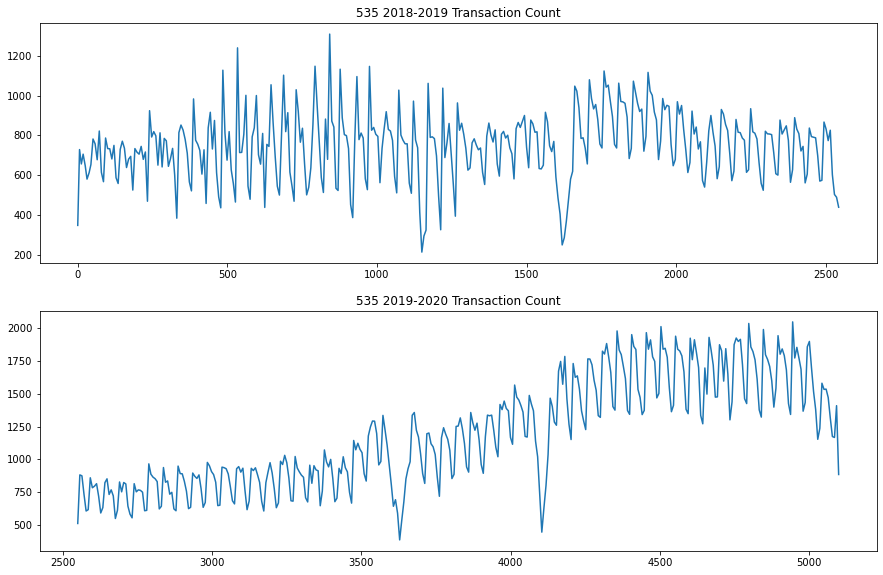

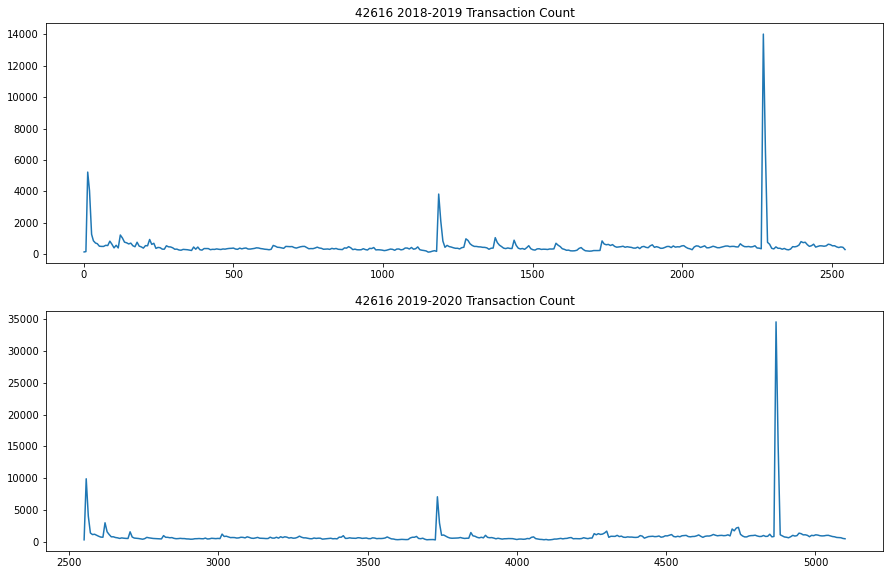

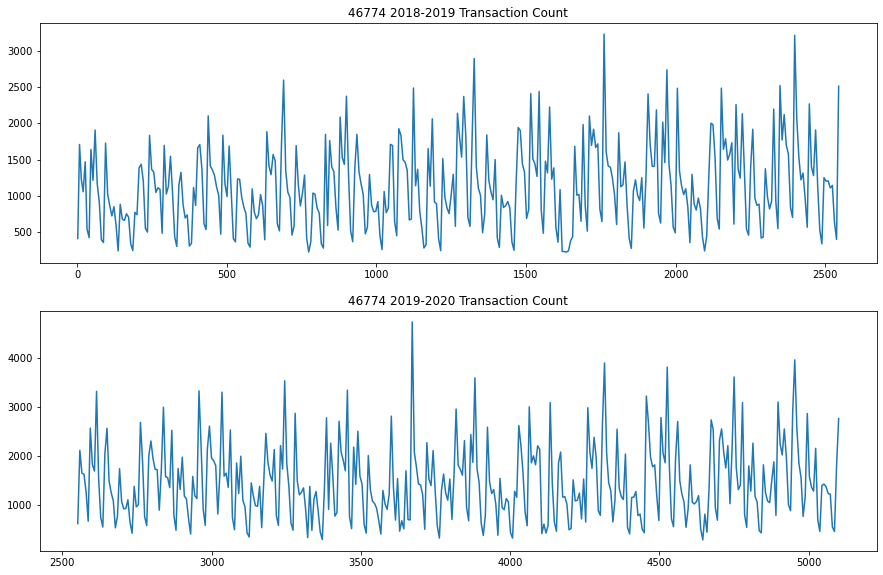

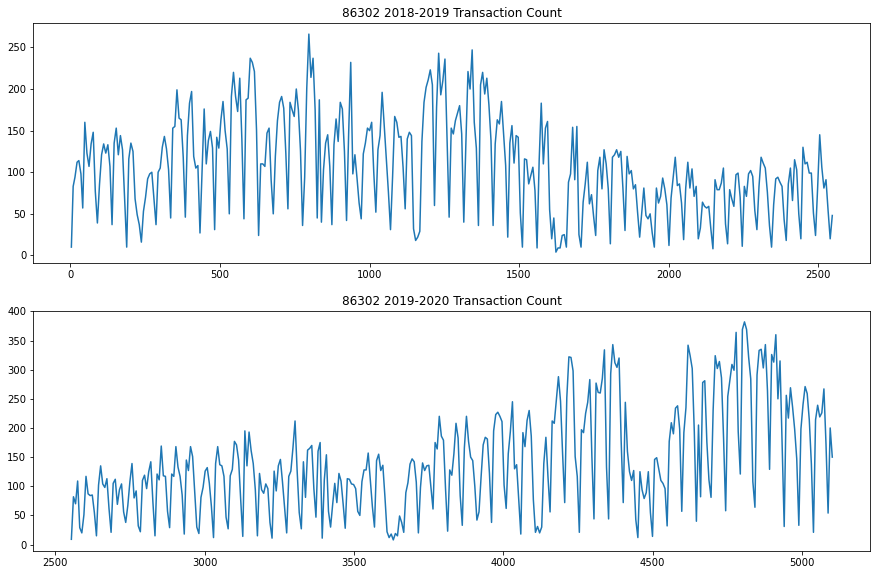

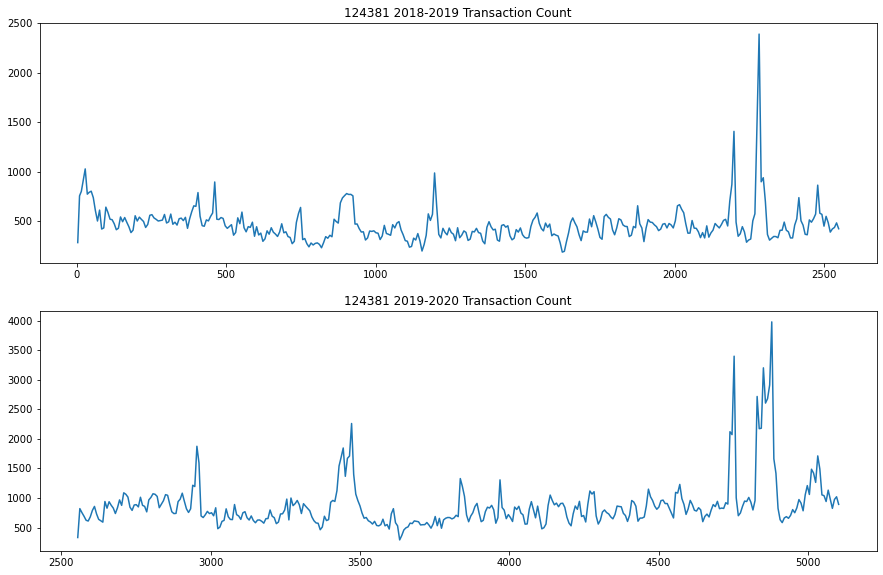

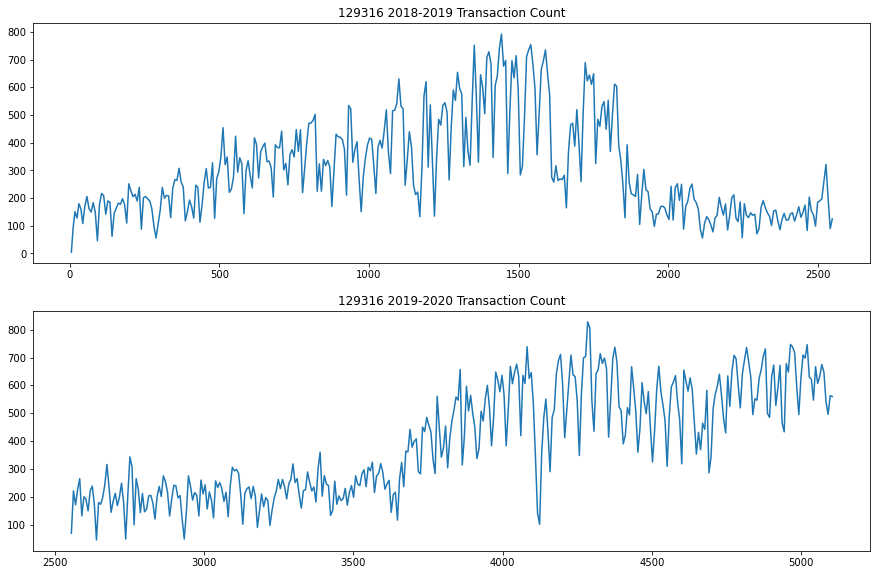

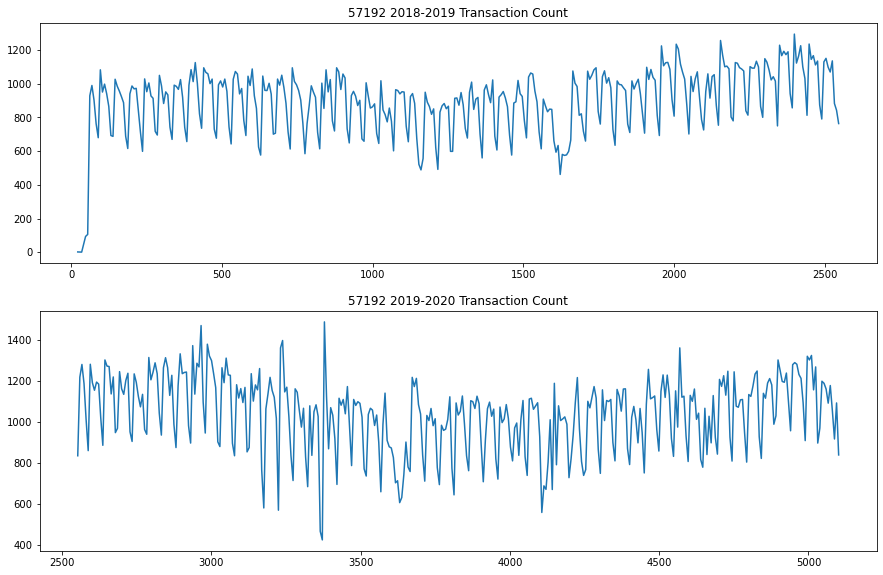

In [6]:
for id in df.merchant_id.unique():
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 1, 1, title = str(id) + ' 2018-2019 Transaction Count')
    df[(df.merchant_id == id) & ( df.transaction_date >= "2018-01-01" ) & (df.transaction_date < "2019-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.subplot(3, 1, 2,title = str(id) + ' 2019-2020 Transaction Count')
    df[(df.merchant_id == id) &( df.transaction_date >= "2019-01-01" )& (df.transaction_date < "2020-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.show()

### Feature Engineering

In [7]:
def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

df = create_date_features(df, "transaction_date")
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [8]:
# Examining the number of transactions of member businesses on a yearly and monthly basis.
df.groupby(["merchant_id","year","month","day_of_month"]).agg({"Total_Transaction": ["sum", "mean", "median"]})

Total_Transaction                    
                                                  sum      mean    median
merchant_id year month day_of_month                                      
535         2018 1     1                          349   349.000   349.000
                       2                          729   729.000   729.000
                       3                          657   657.000   657.000
                       4                          706   706.000   706.000
                       5                          648   648.000   648.000
                       6                          581   581.000   581.000
                       7                          613   613.000   613.000
                       8                          654   654.000   654.000
                       9                          782   782.000   782.000
                       10                         758   758.000   758.000
                       11                         678   678.000   678.000
                       12                         822   822.000   822.000
                       13                         615   615.000   615.000
                       14                         568   568.000   568.000
                       15                         787   787.000   787.000
                       16                         734   734.000   734.000
                       17                         733   733.000   733.000
                       18                         682   682.000   682.000
                       19                         750   750.000   750.000
                       20                         588   588.000   588.000
                       21                         559   559.000   559.000
                       22                         730   730.000   730.000
                       23                         771   771.000   771.000
                       24                         736   736.000   736.000
                       25                         639   639.000   639.000
                       26                         681   681.000   681.000
                       27                         695   695.000   695.000
                       28                         526   526.000   526.000
                       29                         734   734.000   734.000
                       30                         716   716.000   716.000
                       31                         706   706.000   706.000
                 2     1                          745   745.000   745.000
                       2                          680   680.000   680.000
                       3                          717   717.000   717.000
                       4                          470   470.000   470.000
                       5                          924   924.000   924.000
                       6                          792   792.000   792.000
                       7                          819   819.000   819.000
                       8                          798   798.000   798.000
                       9                          651   651.000   651.000
                       10                         813   813.000   813.000
                       11                         642   642.000   642.000
                       12                         785   785.000   785.000
                       13                         773   773.000   773.000
                       14                         645   645.000   645.000
                       15                         684   684.000   684.000
                       16                         735   735.000   735.000
                       17                         601   601.000   601.000
                       18                         385   385.000   385.000
                       19                         814   814.000   814.000
                       20                         852   852.000   852.000
                       21               

In [9]:
# Review of total payment amounts of member businesses on a yearly and monthly basis
df.groupby(["merchant_id","year","month"]).agg({"Total_Paid": ["sum", "mean", "median"]})

Total_Paid                        
                                 sum        mean      median
merchant_id year month                                      
535         2018 1       2091231.810   67459.091   71088.660
                 2       2060521.056   73590.038   73345.545
                 3       2371568.274   76502.202   71045.640
                 4       2504558.754   83485.292   83215.548
                 5       2831761.170   91347.135   90838.422
                 6       2433137.958   81104.599   84910.374
                 7       2741248.350   88427.366   89439.408
                 8       2724770.016   87895.807   91272.600
                 9       3130433.640  104347.788  105952.887
                 10      3187022.904  102807.190  106419.402
                 11      2969292.870   98976.429  100661.193
                 12      2897518.086   93468.325   98468.460
            2019 1       3012663.546   97182.695  100325.430
                 2       2913564.600  104055.879  106919.100
                 3       3653312.400  117848.787  121570.200
                 4       3825828.000  127527.600  130296.600
                 5       4522995.000  145903.065  144327.600
                 6       3733479.000  124449.300  131012.100
                 7       4807756.800  155088.929  154940.400
                 8       5183447.400  167207.981  171651.600
                 9       5772501.000  192416.700  187962.300
                 10      6200688.600  200022.213  208414.800
                 11      5731187.400  191039.580  191918.700
                 12      5389331.400  173849.400  181364.400
            2020 1       5540085.000  178712.419  181672.200
                 2       5679129.600  195832.055  196333.200
                 3       5046521.400  162791.013  165427.200
                 4       2651133.600   88371.120   90406.800
                 5       4050770.400  130670.013  134643.600
                 6       5982942.600  199431.420  197161.200
                 7       6654499.200  214661.265  218934.000
                 8       7193736.000  232056.000  242809.200
                 9       7417445.400  247248.180  250673.400
                 10      7411237.200  239072.168  239193.000
                 11      6556854.600  218561.820  222322.500
                 12      5727355.200  184753.394  194108.400
42616       2018 1       5212777.500  168154.113  112042.386
                 2       2316265.344   82723.762   78970.725
                 3       2637676.206   85086.329   82773.486
                 4       3027473.946  100915.798   96668.316
                 5       2430841.824   78414.252   74222.712
                 6       3802119.642  126737.321   87413.139
                 7       3184093.764  102712.702   94726.710
                 8       2343697.452   75603.144   76631.922
                 9       3927060.072  130902.002  134526.258
                 10      4696554.564  151501.760  148425.246
                 11     11263872.258  375462.409  165139.416
                 12      5071378.950  163592.869  163948.194
            2019 1       9941119.974  320681.289  171874.602
                 2       3869385.714  138192.347  132440.868
                 3       5251799.592  169412.890  160338.798
                 4       4916282.382  163876.079  163696.698
                 5       4703155.254  151714.686  150107.760
                 6       6255960.642  208532.021  131722.560
                 7       4211590.518  135857.759  124185.114
                 8       4210738.794  135830.284  138070.116
                 9       8183844.036  272794.801  262108.260
                 10      9278034.048  299291.421  300125.106
                 11     27843664.266  928122.142  352620.693
                 12      9976568.508  321824.791  338991.804
            2020 1      21376806.138  689574.392  476729.010
                 2       9747831.960  336132.137  305927.928
                 3      10390797.936  335187.030  298221.876


### Lag/Shifted Features

In [10]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

### Rolling Mean Features

In [11]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby("merchant_id")['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

### Exponentially Weighted Mean Features

In [12]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

### Black Friday - Summer Solstice

In [13]:
df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22","2018-11-23","2019-11-29","2019-11-30"]) ,"is_black_friday"]=1

df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin(["2018-06-19","2018-06-20","2018-06-21","2018-06-22",
                                    "2019-06-19","2019-06-20","2019-06-21","2019-06-22",]) ,"is_summer_solstice"]=1

In [14]:
# One-Hot Encoding
df.head()

df = pd.get_dummies(df, columns=['merchant_id','day_of_week', 'month'])
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)

########################
## Custom Cost Function
########################

### MAE: mean absolute error
### MAPE: mean absolute percentage error
### SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)


In [15]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

### Time-Based Validation Sets

In [16]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Train set until the 10th month of 2020.
train = df.loc[(df["transaction_date"] < "2020-10-01"), :]

# Validation set for the last 3 months of 2020.
val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

cols = [col for col in train.columns if col not in ['transaction_date', 'id', "Total_Transaction","Total_Paid", "year" ]]

Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

# control
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 212), (644,), (644, 212))

## LightGBM Model

In [19]:
import lightgbm as lgb
import numpy as np

# Assuming you already have these functions and data ready
# lgbm_smape is your custom evaluation function
# smape is your function for calculating SMAPE

# LightGBM parameters
lgb_params = {
    'metric': 'mae',  # Define the metric
    'num_leaves': 10,  # Maximum number of leaves per tree
    'learning_rate': 0.02,  # Step size for learning
    'feature_fraction': 0.8,  # Fraction of features to use
    'max_depth': 5,  # Maximum depth of each tree
    'verbose': 0,  # Verbosity level
    'num_boost_round': 1000,  # Number of boosting rounds
    'nthread': -1,  # Use all threads available
    'early_stopping_round': 200  # Early stopping after 200 rounds if no improvement
}

# Create LightGBM datasets
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

# Train the model
model = lgb.train(
    lgb_params, 
    lgbtrain, 
    valid_sets=[lgbtrain, lgbval],  # Validation data for early stopping
    num_boost_round=lgb_params['num_boost_round'],  # Number of boosting rounds
    feval=lgbm_smape  # Custom evaluation function
)

# Make predictions on the validation set
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# Calculate SMAPE (Symmetric Mean Absolute Percentage Error)
smape_value = smape(np.expm1(y_pred_val), np.expm1(Y_val))

print("Validation SMAPE:", smape_value)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

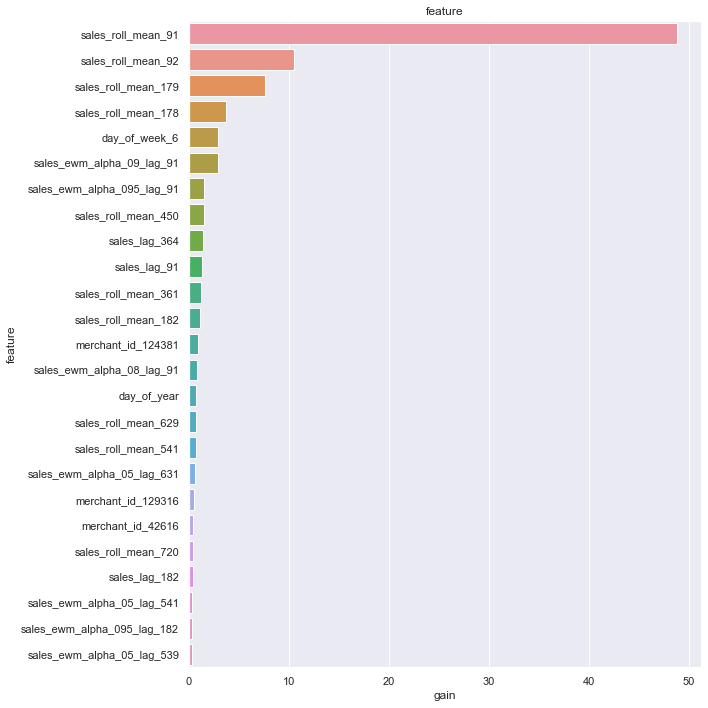

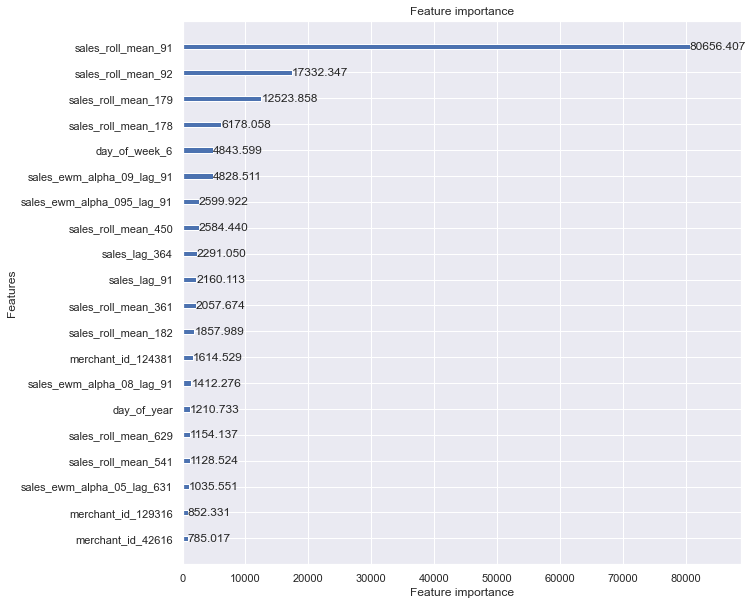

In [20]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()